## Diffusion preprocessing 

Diffusion preprocessing typically comprises of a series of steps, which may vary depending on how the data is acquired. Some consensus has been reached for certain preprocessing steps, while others are still up for debate. The lesson will primarily focus on the preprocessing steps where consensus has been reached. Preprocessing is performed using a few well-known software packages (e.g. FSL, ANTs). For the purposes of these lessons, preprocessing steps requiring these software packages has already been performed for the dataset `ds000221` and the commands required for each step will be provided. This dataset contains single shell diffusion data with 7 b=0 s/mm^2 volumes (non-diffusion weighted) and 60 b=1000 s/mm^2 volumes. In addition, field maps (found in the `fmap` directory are acquired with opposite phase-encoding directions).

To illustrate what the preprocessing step may look like, here is an example preprocessing workflow from qsiprep:
![preprocess](../../fig/2/preprocess_steps.jpg)

dMRI has some similar challenges to fMRI preprocessing, as well as some unique [ones](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3366862/).

Our preprocesssing of this data will consist of following steps and will make use of sub-010006: 
1. Brainmasking the diffusion data
2. Applying FSL `topup` to correct for susceptibility induced distortions
3. FSL Eddy current distortion correction 
4. Registration to T1w

### Brainmasking

The first step to the preprocessing workflow is to create an appropriate brainmask from the diffusion data! Start, by first importing the necessary modules. and reading the diffusion data! We will also grab the anatomical T1w image to use later on, as well as the second inversion from the anatomical acquisition for brainmasking purposes.

In [1]:
from bids.layout import BIDSLayout

layout = BIDSLayout("../../data/ds000221", validate=False)

subj='010006'

# Diffusion data
dwi = layout.get(subject=subj, suffix='dwi', extension='nii.gz', return_type='file')[0]

# Anatomical data
t1w = layout.get(subject=subj, suffix='T1w', extension='nii.gz', return_type='file')[0]

/home/tkai/opt/venv/dipyvenv/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [2]:
import numpy as np
import nibabel as nib

dwi = nib.load(dwi)
dwi_affine = dwi.affine
dwi_data = dwi.get_fdata()

DIPY's `segment.mask` module will be used to create a brainmask from this. This module contains a function `median_otsu`, which can be used to segment the brain and provide a binary brainmask! Here, a brainmask will be created using the first non-diffusion volume of the data. We will save this brainmask to be used in our later future preprocessing steps!

In [6]:
import os
from dipy.segment.mask import median_otsu

# vol_idx is a 1D-array containing the index of the first b0
dwi_brain, dwi_mask = median_otsu(dwi_data, vol_idx=[0])

# Create necessary folders to save mask
out_dir = '../../data/ds000221/derivatives/uncorrected/sub-%s/ses-01/dwi/' % subj

# Check to see if directory exists, if not create one
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

img = nib.Nifti1Image(dwi_mask.astype(np.float32), dwi_affine)
nib.save(img, os.path.join(out_dir, "sub-%s_ses-01_brainmask.nii.gz" % subj))

Text(0.5, 1.0, 'DWI Mask')

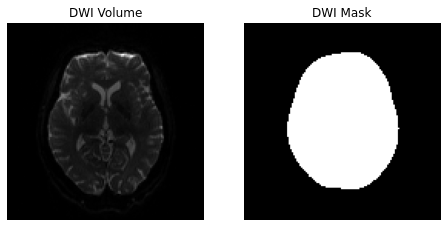

In [30]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.viz import regtools

f = plt.figure(figsize=(12,5))

# Plot brain
plt.subplot(1,3,1).set_axis_off()
t1w = nib.load("/scratch/tkai/SDC-BIDS-dMRI/data/ds000221/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi.nii.gz")
t1w = t1w.get_fdata()
plt.imshow(t1w[:,:,40,0].T, cmap="gray", origin="lower")
plt.title("DWI Volume")

# Plot mask
plt.subplot(1,3,2).set_axis_off()
mask = nib.load("/scratch/tkai/SDC-BIDS-dMRI/data/ds000221/derivatives/uncorrected/sub-010006/ses-01/dwi/sub-010006_ses-01_brainmask.nii.gz")
mask = mask.get_fdata()
plt.imshow(mask[:,:,44].T, cmap="gray", origin="lower")
plt.title("DWI Mask")

# Plot segmented
# plt.subplot(1,3,3).set_axis_off()
# brain = nib.load("/scratch/tkai/SDC-BIDS-dMRI/data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain.nii.gz")
# brain = brain.get_fdata()
# plt.imshow(brain[:,:,180].T, cmap="gray", origin="lower")
# plt.title("Segmented T1-weighted Volume")

# f.savefig("/scratch/tkai/SDC-BIDS-dMRI/fig/2/T1w_brainmask.png")

![](../../fig/2/brainmask.png)

We will also create a brainmask for our T1w image (with FSL `bet`)

In [3]:
%%bash

mkdir -p ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat

# Create a mask via FSL bet
bet ../../data/ds000221/sub-010006/ses-01/anat/sub-010006_ses-01_acq-mp2rage_T1w.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_brain -m

# Move file to more BIDS-esque naming.
mv ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_brain_mask.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_brainmask.nii.gz

![](../../fig/2/T1w_brainmask.png)

In [29]:
%%bash
ls

02-diffusion-preprocessing.ipynb


After creating the brainmask, we will start to correct for distortions in our images.

### FSL [`topup`](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup)

Diffusion images, typically acquired using spin-echo echo planar imaging (EPI), are sensitive to non-zero off-resonance fields. One source of these fields is from the susceptibilitiy distribution of the subjects head, otherwise known as susceptibility-induced off-resonance field. This field is approximately constant for all acquired diffusion images. As such, for a set of diffusion volumes, the susceptibility-induced field will be consistent throughout. This is mainly a problem due to geometric mismatches with the anatomical images (e.g. T1w), which are typically unaffected by such distortions.

`topup`, part of the FSL library, estimates and attempts to correct the susceptibility-induced off-resonance field by using 2 (or more) acquisitions, where the acquisition parameters differ such that the distortion differs. Typically, this is done using two acquisitions acquired with opposite phase-encoding directions, which results in the same field creating distortions in opposing directions.

Here, we will make use of the two opposite phase-encoded acquisitions found in the `fmap` directory of each subjet. These are acquired with a diffusion weighting of b = 0 s/mm^2. Alternatively, if these are not available, one can also extract and make use of the non-diffusion weighted images (assuming the data is also acquired with opposite phase encoding directions).

First, we will merge the two files so that all of the volumes are in 1 file.

In [1]:
%%bash

mkdir -p ../../data/ds000221/derivatives/uncorrected_topup/sub-010006/ses-01/dwi/work

fslmerge -t ../../data/ds000221/derivatives/uncorrected_topup/sub-010006/ses-01/dwi/work/sub-010006_ses-01_acq-SEfmapDWI_epi.nii.gz ../../data/ds000221/sub-010006/ses-01/fmap/sub-010006_ses-01_acq-SEfmapDWI_dir-AP_epi.nii.gz ../../data/ds000221/sub-010006/ses-01/fmap/sub-010006_ses-01_acq-SEfmapDWI_dir-PA_epi.nii.gz

02-diffusion-preprocessing.ipynb


Another file we will need to create is a text file containing the information about how the volumes were acquired. Each line in this file will pertain to a single volume in the merged file. The first 3 values of each line refers to the acquisition direction, typically along the y-axis (or anterior-posterior). The final value is the total readout time (from center of first echo to center of final echo), which can be determined from values contained within the json sidecar. Each line will look similar to `[x y z TotalReadoutTime]`. In this case, the file, which we created, is contained within the `pedir.txt` file in the derivative directory. 

```
0 1 0 0.04914
0 1 0 0.04914
0 1 0 0.04914
0 -1 0 0.04914
0 -1 0 0.04914
0 -1 0 0.04914
```

With these two inputs, the next step is to make the call to `topup` to estimate the susceptibility-induced field. Within the call, a few parameters are used. Briefly:
 * `--imain` specifies the previously merged volume
 * `--datain` specifies the text file containing the information regarding the acquisition. 
 * `--config=b02b0.cnf` makes use of a predefined config file supplied with `topup`, which contains parameters useful to registering with good b=0 s/mm^2 images. 
 * `--out` defines the output files containing the spline coefficients for the induced field, as well as subject movement parameters

In [ ]:
topup --imain=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/work/sub-010006_ses-01_acq-SEfmapDWI_epi.nii.gz --datain=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/work/pedir.txt --config=b02b0.cnf --out=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/work/topup

Next, we can apply the correction to the entire diffusion weighted volume by using `applytopup` Similar to `topup`, a few parameters are used. Briefly:
  * `--imain` specifies the input diffusion weighted volume
  * `--datain` again specifies the text file containing information regarding the acquisition - same file previously used
  * `--inindex` specifies the index (comma separated list) of the input image to be corrected
  * `--topup` name of field/movements (from previous topup step
  * `--out` basename for the corrected output image
  * `--method` (optional) macobian modulation (jac) or least-squares resampling (lsr)

In [ ]:
applytopup --imain=../../data/ds000221/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi.nii.gz --datain=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/work/pedir.txt --inindex=1 --topup=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/work/topup --out=../../data/ds000221/derivatives/topup/sub-010006/ses-01/dwi/dwi --method=jac

# INCLUDE SCREENSHOT HERE

### FSL [`Eddy`](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy)

Another source of the non-zero off resonance fields is caused by the rapid switching of diffusion weighting gradients, otherwise known as eddy current-induced off-resonance fields. Additionally, the subject is likely to move during the diffusion protocol, which may be lengthy.

`eddy`, also part of the FSL library, attempts to correct for both eddy current-induced fields and subject movement by reading the gradient table and estimating the distortion volume by volume. This tool is also able to optionally detect and replace outlier slices.

Here, we will demonstrate the application of `eddy` following the `topup` correction step, by making use of both the uncorrected diffusion data, as well as distortion corrections from the previous step. Additionally, a text file, which maps each of the volumes to one of the corresponding acquisition directions from the `pedir.txt` file will have to be created. Finally, similar to `topup`, there are also a number of input parameters which have to be specified:

  * `--imain` specifies the undistorted diffusion weighted volume
  * `--mask` specifies the brainmask for the undistorted diffusion weighted volume
  * `--acqp` specifies the the text file containing information regarding the acquisition that was previously used in `topup`
  * `--index` is the text file which maps each diffusion volume to the corresponding acquisition direction
  * `--bvecs` specifies the bvec file to the undistorted dwi
  * `--bvals` similarily specifies the bval file to the undistorted dwi
  * `--topup` specifies the directory and distortion correction files previously estimated by `topup`
  * `--out` specifies the prefix of the output files following eddy correction
  * `--repol` is a flag, which specifies replacement of outliers 

In [ ]:
%%bash

mkdir -p ../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/work

# Create an index file mapping the 67 volumes in 4D dwi volume to the pedir.txt file
indx=""
for i in `seq 1 67`; do 
  indx="$indx 1"
done
echo $indx > ../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/work/index.txt

eddy_openmp --imain=../../data/ds000221/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi.nii.gz --mask=../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/dwi/sub-010006_ses-01_brainmask.nii.gz --acqp=../../data/ds000221/derivatives/uncorrected_topup/sub-010006/ses-01/dwi/work/pedir.txt --index=../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/work/index.txt --bvecs=../../data/ds000221/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi.bvec --bvals=../../data/ds000221/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi.bval --topup=../../data/ds000221/derivatives/uncorrected_topup/sub-010006/ses-01/dwi/work/topup --out=../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/dwi --repol

# INCLUDE SCREENSHOT HERE

### Registration with T1w

The final step to our diffusion processing is registration to an anatomical image (eg. T1-weighted). This is important because the diffusion data, typically acquired using echo planar imaging or EPI, enables faster acquisitions at the cost of lower resolution and introduction of distortions (as seen above). Registration with the anatomical image not only helps to correct for some distortions, it also provides us with a higher resolution, anatomical reference.

First, we will create a brainmask of the anatomical image using the second inversion. To do this, we will use FSL `bet` twice. The first call to `bet` will create a general skullstripped brain. Upon inspection, we can note that there is still some residual areas of the image which were included in the first pass. Calling `bet` a second time, we get a better outline of the brain and brainmask, which we can use for further processing.

In [3]:
%%bash

mkdir -p ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat

bet ../../data/ds000221/sub-010006/ses-01/anat/sub-010006_ses-01_inv-2_mp2rage.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_broadbrain -f 0.6
bet ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_broadbrain ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain -f 0.4 -m

mv ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain_mask.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brainmask.nii.gz

bash: line 4: bet: command not found
mv: cannot stat '../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain_mask.nii.gz': No such file or directory


CalledProcessError: Command 'b'\nmkdir -p ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat\n\nbet ../../data/ds000221/sub-010006/ses-01/anat/sub-010006_ses-01_inv-2_mp2rage.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain -m -n -f 0.6\n\nmv ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain_mask.nii.gz ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brainmask.nii.gz\n'' returned non-zero exit status 1.

Note, we use `bet` here, as well as the second inversion of the anatomical image, as it provides us with a better brainmask. The `bet` command above is called to output only the binary mask and the fractional intensity threshold is also increased slightly (to 0.6) provide a smaller outline of the brain initially, and then decreased (to 0.4) to provide a larger outline. The flag`-m` indicates to the tool to create a brainmask in addition to outputting the extracted brain volume. Both the mask and brain volume will be used in our registration step.

Before we get to the registration, we will also perform a brain extraction using `dipy` on the eddy corrected image. Note that the output of `eddy`is not in BIDS format so we will include the path to the diffusion data manually. We will save both the brainmask and the extracted brain volume. Additionally, we will save a separate volume of only the first b0 to use for the registration. 

In [4]:
from dipy.segment.mask import median_otsu

# Path of FSL eddy-corrected dwi
dwi = "../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/dwi.nii.gz"

# Load eddy-corrected diffusion data
dwi = nib.load(dwi)
dwi_affine = dwi.affine
dwi_data = dwi.get_fdata()

dwi_brain, dwi_mask = median_otsu(dwi_data, vol_idx=[0])
dwi_b0 = dwi_brain[:,:,:,0]

# Output directory
out_dir="../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi"

# Save diffusion mask
img = nib.Nifti1Image(dwi_mask.astype(np.float32), dwi_affine)
nib.save(img, os.path.join(out_dir, "sub-010006_ses-01_dwi_proc-eddy_brainmask.nii.gz"))

# Save 4D diffusion volume
img = nib.Nifti1Image(dwi_brain, dwi_affine)
nib.save(img, os.path.join(out_dir, "sub-010006_ses-01_dwi_proc-eddy_brain.nii.gz"))

# Save b0 volume
img = nib.Nifti1Image(dwi_b0, dwi_affine)
nib.save(img, os.path.join(out_dir, "sub-010006_ses-01_dwi_proc-eddy_b0.nii.gz"))

To perform the registration between the diffusion volumes and T1w, we will make use of ANTs, specifically the `antsRegistrationSyNQuick.sh` script and `antsApplyTransform`. We will begin by registering the diffusion b=0 s/mm^2 volume to get the appropriate transforms to align the two images. We will then apply the inverse transformation to the T1w volume such that it is aligned to the diffusion volume

Here, we will constrain `antsRegistrationSyNQuick.sh` to perform a rigid and affine transformation (we will explain why in the final step). There are a few parameters that must be set:

* `-d` - Image dimension (2/3D)
* `-t` - Transformation type (`a` performs only rigid + affine transformation)
* `-f` - Fixed image (anatomical T1w)
* `-m` - Moving image (DWI b=0 s/mm^2)
* `-o` - Output prefix (prefix to be appended to output files)

In [9]:
%%bash

mkdir -p ../../data/ds000221/derivatives/uncorrected_topup_eddy_regT1/sub-010006/ses-01/transforms

# Perform registration between b0 and T1w
antsRegistrationSyNQuick.sh -d 3 -t a -f ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain.nii.gz -m ../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi_proc-eddy_b0.nii.gz -o ../../data/ds000221/derivatives/uncorrected_topup_eddy_regT1/sub-010006/ses-01/transform/dwi_to_t1_

The transformation file should be created which we will use to apply the inverse transform with `antsApplyTransform` to the T1w volume. Similar to the previous command, there are few parameters that will need to be set:

* `-d` - Image dimension (2/3/4D)
* `-i` - Input volume to be transformed (T1w)
* `-r` - Reference volume (b0 of DWI volume)
* `-t` - Transformation file (can be called more than once)
* `-o` - Output volume in the transformed space.

Note that if more than 1 transformation file is provided, the order in which the transforms are applied to the volume is in reverse order of how it is inputted (e.g. last transform gets applied first). 

In [ ]:
%%bash

# Apply transform to 4D DWI volume
antsApplyTransforms -d 3 -i ../../data/ds000221/derivatives/uncorrected/sub-010006/ses-01/anat/sub-010006_ses-01_space-T1w_brain.nii.gz -r ../../data/ds000221/derivatives/uncorrected_topup_eddy/sub-010006/ses-01/dwi/sub-010006_ses-01_dwi_proc-eddy_b0.nii.gz -t [../../data/ds000221/derivatives/uncorrected_topup_eddy_regT1/sub-010006/ses-01/transform/dwi_to_t1_0GenericAffine.mat,1] -o ../../data/ds000221/derivatives/uncorrected_topup_eddy_regT1/sub-010006/ses-01/anat/sub-010006_ses-01_space-dwi_T1w_brain.nii.gz

## INSERT OVERLAY OF TRANSFORMED IMAGE

Following the transformation of the T1w volume, we can see that anatomical and diffusion weighted volumes are now aligned. It should be highlighted that as part of the transformation step, the T1w volume is resampled based on the voxel size of the ference volume (e.g. DWI).

### Preprocessing notes:

1. In this lesson, the T1w volume is registered to the DWI volume. This method minimizes the manipulation of the diffusion data. It is also possible to register the DWI volume to the T1w volume and would require the associated diffusion gradient vectors (bvec) to also be similarly rotated. If this step is not performed, one would have incorrect diffusion gradient directions relative to the registered DWI volumes. This also highlights a reason behind not performing a non-linear transformation for registration, as each individual diffusion gradient direction would also have to be subsequently warped. Rotation of the diffusion gradient vectors can be done by applying the affine transformation to each row of the file. Luckily, there are existing scripts that can do this. One such Python script was created by Michael Paquette: [`rot_bvecs_ants.py`](https://gist.github.com/mpaquette/5d59ad195778f9d984c5def42f53de6e).  

2. We have only demonstrated the preprocessing steps where there is general consensus on how DWI data should be processed. There are also additional steps with certain caveats, which include denoising, unringing (to remove/minimize effects of Gibbs ringing artifactS), and gradient non-linearity correction (to unwarp distortions caused by gradient-field inhomogeneities using a vendor acquired gradient coefficient file.
    
3. Depending on how the data is acquired, certain steps may not be possible. For example, if the data is not acquired in two directions, `topup` may not be possible (in this situation, distortion correction may be better handled by registering with a T1w anatomical image directly.

4. There are also a number of tools available for preprocessing. In this lesson, we demonstrate some of the more commonly used tools alongside `dipy`.